# Wind Speed Prediction

## Imports

In [59]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
import shap

[Kaggle Dataset](https://www.kaggle.com/datasets/fedesoriano/wind-speed-prediction-dataset/data)

Columns:

    - DATE (YYYY-MM-DD)
    - WIND: Average wind speed [knots]
    - IND: First indicator value
    - RAIN: Precipitation Amount (mm)
    - IND.1: Second indicator value
    - T.MAX: Maximum Temperature (°C)
    - IND.2: Third indicator value
    - T.MIN: Minimum Temperature (°C)
    - T.MIN.G: 09utc Grass Minimum Temperature (°C)

## Dataset

In [60]:
df = pd.read_csv('wind_dataset.csv', parse_dates=True, index_col=0)
df.head()

,WIND,IND,RAIN,IND.1,T.MAX,IND.2,T.MIN,T.MIN.G
DATE,,,,,,,,
1961-01-01,13.67,0,0.2,0.0,9.5,0.0,3.7,-1.0
1961-01-02,11.50,0,5.1,0.0,7.2,0.0,4.2,1.1
1961-01-03,11.25,0,0.4,0.0,5.5,0.0,0.5,-0.5
1961-01-04,8.63,0,0.2,0.0,5.6,0.0,0.4,-3.2
1961-01-05,11.92,0,10.4,0.0,7.2,1.0,-1.5,-7.5


In [61]:
df.shape

(6574, 8)

In [62]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6574 entries, 1961-01-01 to 1978-12-31
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   WIND     6574 non-null   float64
 1   IND      6574 non-null   int64  
 2   RAIN     6574 non-null   float64
 3   IND.1    6513 non-null   float64
 4   T.MAX    5953 non-null   float64
 5   IND.2    6513 non-null   float64
 6   T.MIN    5900 non-null   float64
 7   T.MIN.G  6214 non-null   float64
dtypes: float64(7), int64(1)
memory usage: 462.2 KB


In [63]:
df.isnull().sum()

WIND         0
IND          0
RAIN         0
IND.1       61
T.MAX      621
IND.2       61
T.MIN      674
T.MIN.G    360
dtype: int64

In [64]:
for col in df.columns:
    df[col].fillna(df[col].mode()[0], inplace=True)

df.isnull().sum()

WIND       0
IND        0
RAIN       0
IND.1      0
T.MAX      0
IND.2      0
T.MIN      0
T.MIN.G    0
dtype: int64

In [65]:
summary = df.describe().transpose().round(2)
summary

,count,mean,std,min,25%,50%,75%,max
WIND,6574.0,9.80,4.98,0.0,6.0,9.21,12.96,30.37
IND,6574.0,0.39,1.18,0.0,0.0,0.00,0.00,4.00
RAIN,6574.0,1.89,4.03,0.0,0.0,0.20,2.00,67.00
IND.1,6574.0,0.35,1.12,0.0,0.0,0.00,0.00,4.00
T.MAX,6574.0,13.02,4.76,-0.1,10.0,12.40,16.80,26.80
IND.2,6574.0,0.46,1.17,0.0,0.0,0.00,0.00,4.00
T.MIN,6574.0,6.68,4.46,-11.5,3.5,7.30,9.60,18.00
T.MIN.G,6574.0,2.86,5.44,-14.4,-0.9,3.40,6.60,15.80


## Linear Regression Model

In [66]:
X = df.drop('WIND', axis=1)
y = df['WIND']

X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.20, random_state=42)

X_train.shape, X_test.shape

((5259, 7), (1315, 7))

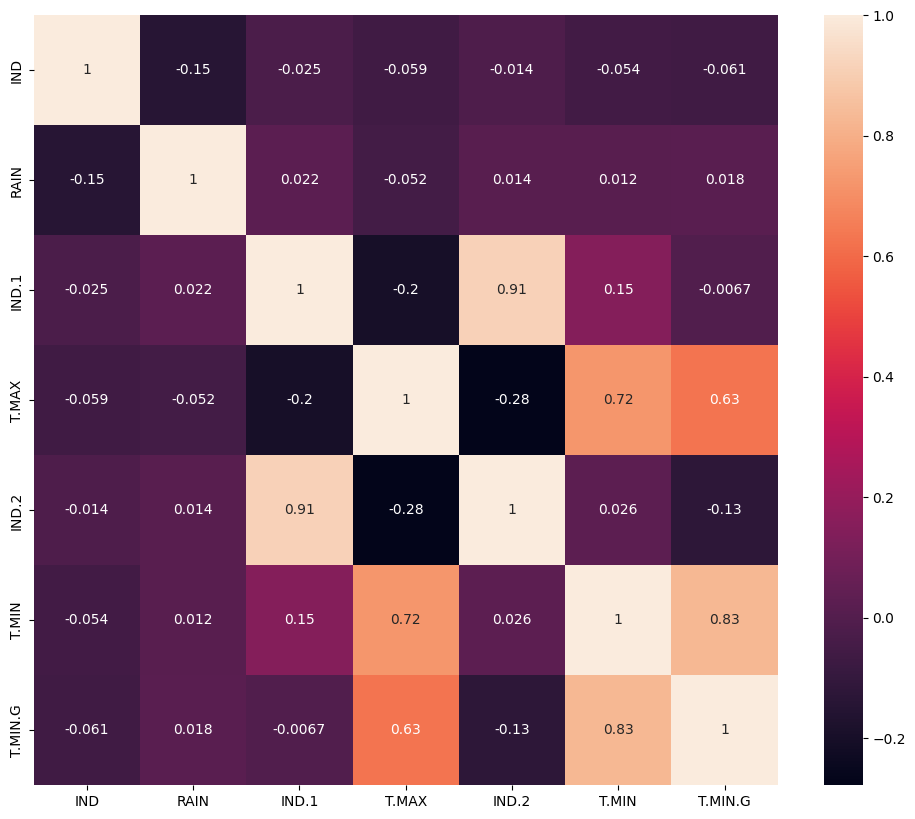

In [67]:
plt.figure(figsize=(12,10))
sns.heatmap(X_train.corr(), annot=True)
plt.show()

# TODO: Multikolinearität, Feature Scaling

In [68]:
linreg = LinearRegression()
linreg.fit(X_train, y_train)
y_pred = linreg.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
train_score = linreg.score(X_train, y_train)
test_score = r2_score(y_test, y_pred)

print("Mean absolute error: ", mae)
print("Mean squared error:  ", mse)
print("Train R2 score:      ", train_score)
print("Test R2 Score:       ", test_score)


Mean absolute error:  3.8004289181127326
Mean squared error:   22.51173379786351
Train R2 score:       0.114196795624943
Test R2 Score:        0.10217840814316148


In [69]:
cdf = pd.DataFrame(linreg.coef_.round(5), X_train.columns, columns=['Coefficients'])
cdf.loc['Intercept'] = linreg.intercept_.round(5)
cdf

,Coefficients
IND,-0.16103
RAIN,0.10506
IND.1,0.53726
T.MAX,-0.42172
IND.2,-0.60416
T.MIN,-0.00879
T.MIN.G,0.23442
Intercept,14.60871


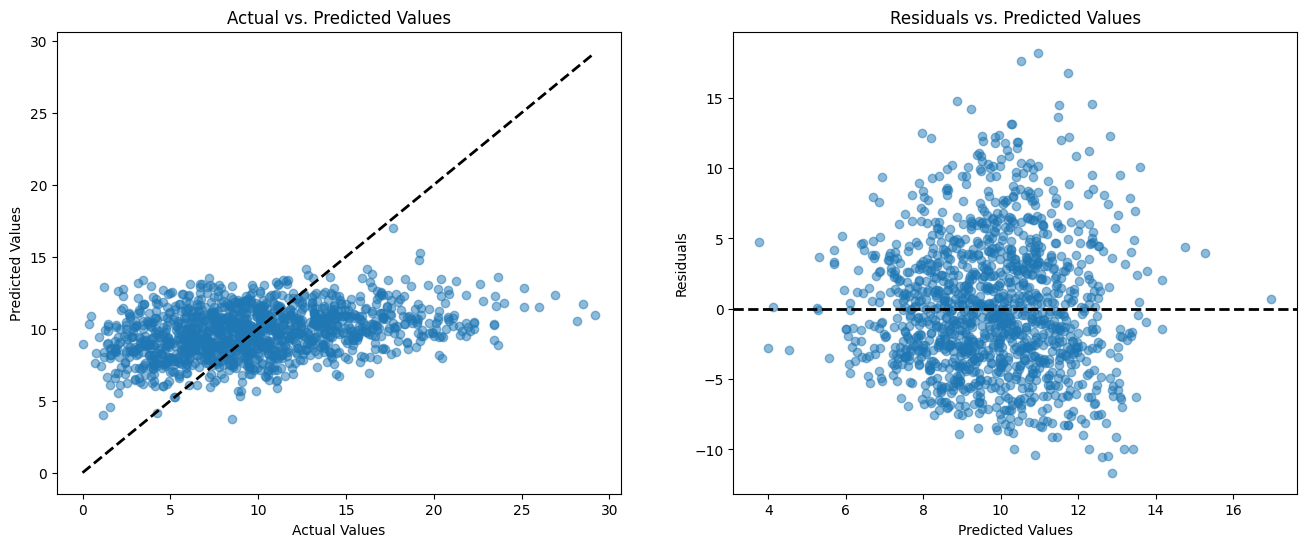

In [84]:
residuals = y_test - y_pred

fig, axs = plt.subplots(1, 2, figsize=(16, 6))

axs[0].scatter(y_test, y_pred, alpha=0.5)
axs[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--k', linewidth=2)
axs[0].set_title('Actual vs. Predicted Values')
axs[0].set_xlabel('Actual Values')
axs[0].set_ylabel('Predicted Values')

axs[1].scatter(y_pred, residuals, alpha=0.5)
axs[1].axhline(y=0, color='k', linestyle='--', linewidth=2)
axs[1].set_title('Residuals vs. Predicted Values')
axs[1].set_xlabel('Predicted Values')
axs[1].set_ylabel('Residuals')

plt.show()

## Shapley Charts

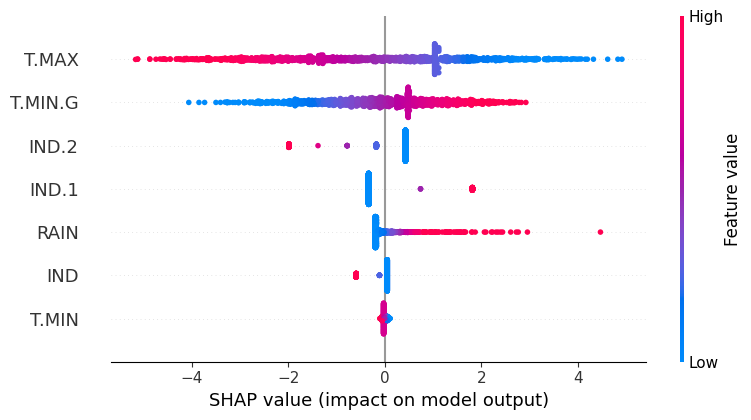

In [85]:
explainer = shap.Explainer(linreg, X_train, algorithm='linear')
shap_values = explainer(X_test)

shap.summary_plot(shap_values, X_test)

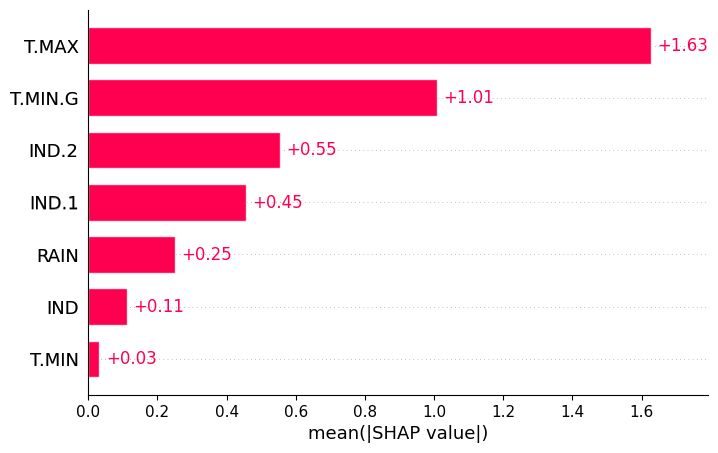

In [71]:
shap.plots.bar(shap_values)

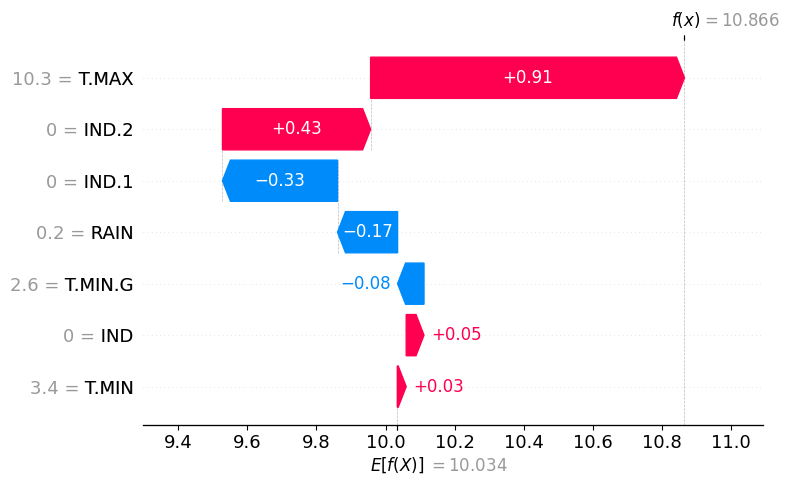

In [81]:
sample_ind = 1
shap.plots.waterfall(shap_values[sample_ind])

In [73]:
shap.plots.force(shap_values[sample_ind])

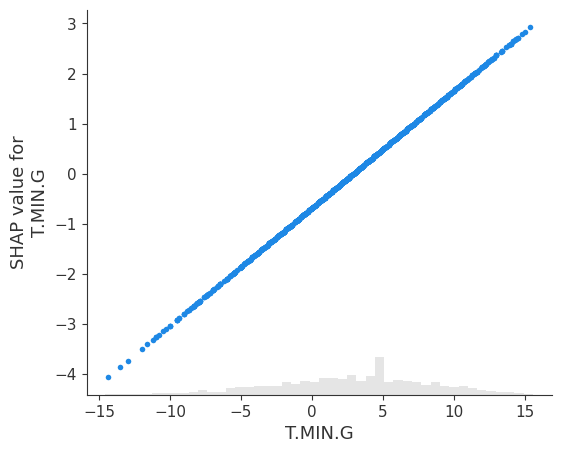

In [74]:
shap.plots.scatter(shap_values[:, "T.MIN.G"])

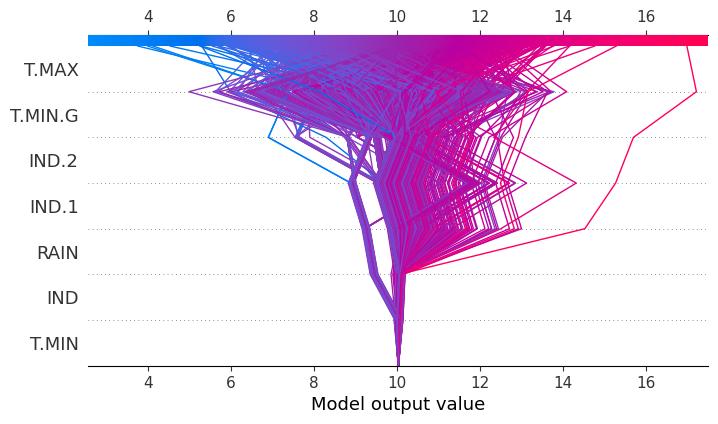

In [75]:
shap.decision_plot(explainer.expected_value, shap_values.values, X_test)